# Prep


In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
cd /content/drive/My Drive/github_drive/code

/content/drive/My Drive/github_drive/code


In [ ]:
# Un-comment and install one package at a time
# !pip install sktime
!pip install lime

### Explain TS with LIME

You can use this piece of codes to replace the utils.lime_timeseries module in utils folder

In [ ]:
import numpy as np
import sklearn
from lime import explanation
from lime import lime_base
import math


class LimeTimeSeriesExplanation(object):
    """Explains time series classifiers."""

    def __init__(self,
                 kernel_width=25,
                 verbose=False,
                 class_names=None,
                 feature_selection='auto',
                 ):
        """Init function.
        Args:
            kernel_width: kernel width for the exponential kernel
            verbose: if true, print local prediction values from linear model
            class_names: list of class names, ordered according to whatever the
            classifier is using. If not present, class names will be '0',
                '1', ...
            feature_selection: feature selection method. can be
                'forward_selection', 'lasso_path', 'none' or 'auto'.
        """

        # exponential kernel
        def kernel(d): return np.sqrt(np.exp(-(d ** 2) / kernel_width ** 2))

        self.base = lime_base.LimeBase(kernel, verbose)
        self.class_names = class_names
        self.feature_selection = feature_selection

    def explain_instance(self,
                         timeseries,
                         classifier_fn,
                         training_set,
                         num_slices,
                         labels=(1,),
                         top_labels=None,
                         num_features=10,
                         num_samples=5000,
                         distance_metric='cosine',
                         model_regressor=None,
                         replacement_method='mean'):
        """Generates explanations for a prediction.
        Args:
            time_series: Time Series to be explained.
            classifier_fn: classifier prediction probability function
            num_slices: Defines into how many slices the series will be split up
            labels: iterable with labels to be explained.
            top_labels: if not None, ignore labels and produce explanations for
            the K labels with highest prediction probabilities, where K is
            this parameter.
            num_features: maximum number of features present in explanation
            num_samples: size of the neighborhood to learn the linear model
            distance_metric: the distance metric to use for sample weighting,
            defaults to cosine similarity
            model_regressor: sklearn regressor to use in explanation. Defaults
            to Ridge regression in LimeBase. Must have model_regressor.coef_
            and 'sample_weight' as a parameter to model_regressor.fit()
        Returns:
            An Explanation object (see explanation.py) with the corresponding
            explanations.
       """
        domain_mapper = explanation.DomainMapper()
        data, yss, distances = self.__data_labels_distances(timeseries, classifier_fn, num_samples, num_slices,
                                                            training_set, replacement_method)
        if self.class_names is None:
            self.class_names = [str(x) for x in range(yss[0].shape[0])]
        ret_exp = explanation.Explanation(domain_mapper=domain_mapper, class_names=self.class_names)
        ret_exp.predict_proba = yss[0]
        for label in labels:
            (ret_exp.intercept[int(label)],
             ret_exp.local_exp[int(label)],
             ret_exp.score, ret_exp.local_pred) = self.base.explain_instance_with_data(data, yss, distances, label,
                                                                                       num_features,
                                                                                       feature_selection=self.feature_selection)
        ret_exp.local_exp = {k: [(int(j1), float(j2)) for j1, j2 in v] for k, v in ret_exp.local_exp.items()}
        return ret_exp

    @classmethod
    def __data_labels_distances(cls,
                                time_series,
                                classifier_fn,
                                num_samples,
                                num_slices,
                                training_set,
                                replacement_method='mean'):
        """Generates a neighborhood around a prediction.
        Generates neighborhood data by randomly removing words from
        the instance, and predicting with the classifier. Uses cosine distance
        to compute distances between original and perturbed instances.
        Args:
            time_series: Time Series to be explained.
            classifier_fn: classifier prediction probability function, which
                takes a time series and outputs prediction probabilities. For
                ScikitClassifier, this is classifier.predict_proba.
            num_samples: size of the neighborhood to learn the linear model
            num_slices: how many slices the time series will be split into for discretization.
            training_set: set of which the mean will be computed to use as 'inactive' values.
            replacement_method: Defines how individual slice will be deactivated (can be 'mean', 'total_mean', 'noise')
        Returns:
            A tuple (data, labels, distances), where:
                data: dense num_samples * K binary matrix, where K is the
                    number of tokens in indexed_string. The first row is the
                    original instance, and thus a row of ones.
                labels: num_samples * L matrix, where L is the number of target
                    labels
                distances: cosine distance between the original instance and
                    each perturbed instance (computed in the binary 'data'
                    matrix), times 100.
        """

        def distance_fn(x):
            return sklearn.metrics.pairwise.pairwise_distances(
                x, x[0].reshape([1, -1]), metric='cosine').ravel() * 100

        # split time_series into slices
        values_per_slice = math.ceil(len(time_series) / num_slices)

        # compute randomly how many slices will be switched off
        sample = np.random.randint(1, num_slices + 1, num_samples - 1)
        data = np.ones((num_samples, num_slices))
        features_range = range(num_slices)
        inverse_data = [time_series.copy()]

        for i, size in enumerate(sample, start=1):
            inactive = np.random.choice(features_range, size, replace=False)
            # set inactive slice to mean of training_set
            data[i, inactive] = 0
            tmp_series = time_series.copy()

            for i, inact in enumerate(inactive, start=1):
                index = inact * values_per_slice
                if replacement_method == 'mean':
                    # use mean as inactive
                    tmp_series[index:(index + values_per_slice)] = np.mean(
                        training_set[:, index:(index + values_per_slice)].mean())
                elif replacement_method == 'noise':
                    # use random noise as inactive
                    tmp_series[index:(index + values_per_slice)] = np.random.uniform(np.amin(training_set),
                                                                                        np.amax(training_set), len(
                            tmp_series[index:(index + values_per_slice)]))
                elif replacement_method == 'total_mean':
                    # use total mean as inactive
                    tmp_series[index:(index + values_per_slice)] = np.mean(training_set.mean())
            inverse_data.append(tmp_series)
        labels = classifier_fn(np.expand_dims(np.asarray(inverse_data), 1))
        distances = distance_fn(data)
        return data, labels, distances

# Get Explanation weights - LIME

In [ ]:
import math
import pandas as pd
import numpy as np
import os

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score 
from sklearn import metrics


from sktime.classification.shapelet_based import MrSEQLClassifier
from sktime.utils.data_processing import from_2d_array_to_nested, is_nested_dataframe

from lime import explanation
from lime import lime_base
# from utils.lime_timeseries import LimeTimeSeriesExplanation

/usr/local/lib/python3.6/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


### 1. Classify by Mr-SEQL

In [ ]:
ds='CMJ'
ds_dir = 'data'

train_file =  os.path.join(ds_dir, ds, ds+'_TRAIN')
test_file  = os.path.join(ds_dir, ds, ds+'_TEST')

# load train data
train_data = np.genfromtxt(train_file,delimiter=',')

train_x = np.expand_dims(train_data[:,1:], 1) # pass a 3D array shape (None, n_channel, channel_val). Pad extra dimension to 2D channel to make it 3D
train_y = train_data[:,0]


ms = MrSEQLClassifier(seql_mode="fs")
ms.fit(train_x,train_y)
    

# load test data
test_data = np.genfromtxt(test_file,delimiter=',')

test_x = np.expand_dims(test_data[:,1:], 1)
test_y = test_data[:,0]

# # prediction
predicted = ms.predict(test_x)

# # Classification accuracy
print("Accuracy with mr-seql: %2.4f" % metrics.accuracy_score(test_y, predicted))

Accuracy with mr-seql: 0.9609


In [ ]:
train_x.shape

(419, 1, 500)

### 2. Get & Save the explanation weights by LIME

In [ ]:
# Reload Test data as 2D array numpy format:
test_x = test_data[:,1:]
train_x = train_data[:,1:]

In [ ]:
num_features = 10
num_slices = 10
num_sample = len(test_y)
explainer = LimeTimeSeriesExplanation(class_names=['0', '1','2'], feature_selection='auto')
features = np.empty(dtype=float, shape=(0,num_features))

# for idx in range(num_sample):
for idx in range(num_sample):
    series = test_x[idx, :]
    exp = explainer.explain_instance(series, ms.predict_proba, num_features=num_features, num_samples=500, num_slices=num_slices, 
                                 replacement_method='total_mean', training_set=train_x)
    temp, ans = [], []
    for i in range(num_features):
        feature, weight = exp.as_list()[i]
        temp.append((feature,weight))
    temp.sort()
    for _, val in temp: ans.append(val)
    features = np.append(features, np.array([ans]), axis = 0)    

print(features.shape)



(179, 10)


### Save the weight to local folder

In [47]:
fileName = 'output/explanation_weight/weights_LIME_%s.txt' % ds

np.savetxt(fileName, features, delimiter=",")

# Visualize Explanation Weight

## Define Function


In [48]:
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy.interpolate import interp1d

def visualize_example(example_idx, explanation_weight , ds = 'CMJ'):
    idx = example_idx
    test_file  = os.path.join(ds_dir, ds, ds+'_TEST')
    test_data = np.genfromtxt(test_file, delimiter=',')
    test_x, test_y  = test_data[:,1:], test_data[:,0]

    le = preprocessing.LabelEncoder()
    le.fit(test_y)
    transformed_test_y = le.transform(test_y)
    n_class = np.unique(transformed_test_y).shape[0]
    
    def transform(X):
        ma,mi = np.max(X), np.min(X)
        X = (X - mi)/(ma-mi)
        return X*100
    weight = abs(explanation_weight[idx])
    weight = transform(weight)
    ts = test_x[idx]
    
    
    max_length1, max_length2 = len(ts),10000 #
    x1 = np.linspace(0,max_length1,num = max_length1)
    x2 = np.linspace(0,max_length1,num = max_length2)
    y1 = ts
    
    f = interp1d(x1, y1) # interpolate time series
    fcas = interp1d(x1, weight) # interpolate weight color
    weight = fcas(x2) # convert vector of original weight vector to new weight vector

    plt.scatter(x2,f(x2), c = weight, cmap = 'jet', marker='.', s= 1,vmin=0,vmax = 100)
    plt.xlabel('Explanation for index %d, dataset %s' %(example_idx, ds))
    plt.show()



def get_explanation_weight(explanation_method, ds):
    test_file  = os.path.join(ds_dir, ds, ds+'_TEST')
    test_data = np.genfromtxt(test_file, delimiter=',')
    test_x, test_y  = test_data[:,1:], test_data[:,0]
    
    if explanation_method == 'MrSEQL-SM':        explanation_weight_file = 'output/explanation_weight/weights_MrSEQL_%s.txt' % ds
    elif explanation_method == 'MrSEQL-LIME':    explanation_weight_file = 'output/explanation_weight/weights_LIME_%s.txt' % ds
    elif explanation_method == 'ResNet-CAM':      explanation_weight_file = 'output/resnet_weights/ResNet_%s_BestModel.hdf5_model_weights.txt' % ds
    else: 
        print('ERROR')
    explanation_weight = np.genfromtxt(explanation_weight_file, delimiter = ',')
    if explanation_method =='MrSEQL-LIME': 
        repeat_times = test_x.shape[1]//10
        explanation_weight = np.repeat(explanation_weight, repeat_times).reshape(test_y.shape[0],-1)
#     explanation_weight = abs(explanation_weight)
    return explanation_weight

## Visualize

In [49]:
example_li  =  [18,70,150] # indices of the examples
ds = 'CMJ'
method = 'MrSEQL-LIME'
weight = get_explanation_weight(explanation_method=method, ds = ds)


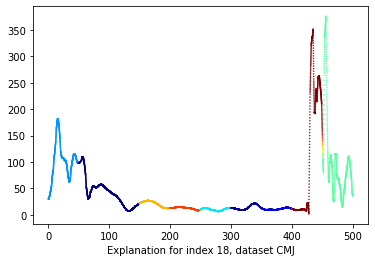

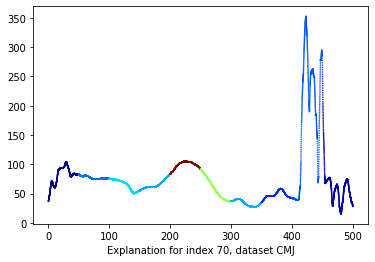

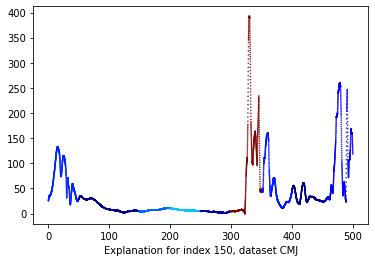

In [50]:
for idx in example_li:
  visualize_example(example_idx= idx, explanation_weight=weight, ds = ds)